In [6]:
!pip install numpy
!pip install pandas
!pip install sklearn
!pip install matplotlib
!pip install seaborn


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

dataset = pd.read_csv('./train_data/train_data.csv')

# "engine_no" and "time_in_cycled" are not required in prediction.
metacol = ['engine_no', 'time_in_cycles']

# ******************* Check Null data *********************** #
null_rate = (dataset.isnull().sum()/dataset.shape[0]) * 100

null_col = []
threshold_ratio = 99.5 #(%)

for i, x in enumerate(null_rate.index):
    if null_rate[i] > threshold_ratio:
        null_col.append(x)

# If Null Ratio is greater than threshold_ratio, drop the column from dataset
dataset = dataset.drop(columns=null_col)
print(f'Droppd columns are: {null_col}')
# ************************************************************ #

# Get Engine No. List
engine_list = dataset['engine_no'].drop_duplicates().values

Droppd columns are: ['sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26', 'sensor_27']


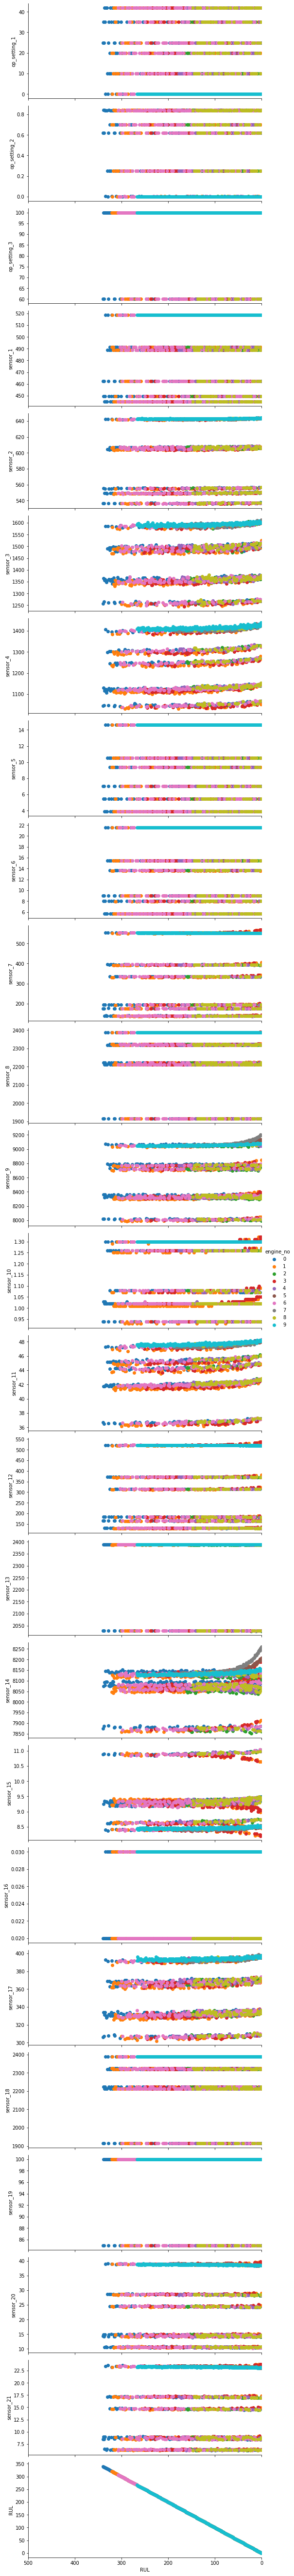

In [21]:
# PairGrid : 3차원 이상의 실수형 데이터를 그래프로 변환 (RUL과 변수 간 관계)
explore = sns.PairGrid(data=dataset.query('engine_no < 10') ,   # 10개 엔진 데이터를 샘플로 표현
                 x_vars=['RUL'],
                 y_vars=dataset.drop(columns=metacol).columns,  # 분석에 필요한 데이터 가져오기 (정제된 데이터)
                 hue="engine_no", height=3, aspect=2.5)     # 그래프에서 나눌 변수의 값

explore = explore.map(plt.scatter)
explore = explore.set(xlim=(500,0))
explore = explore.add_legend()

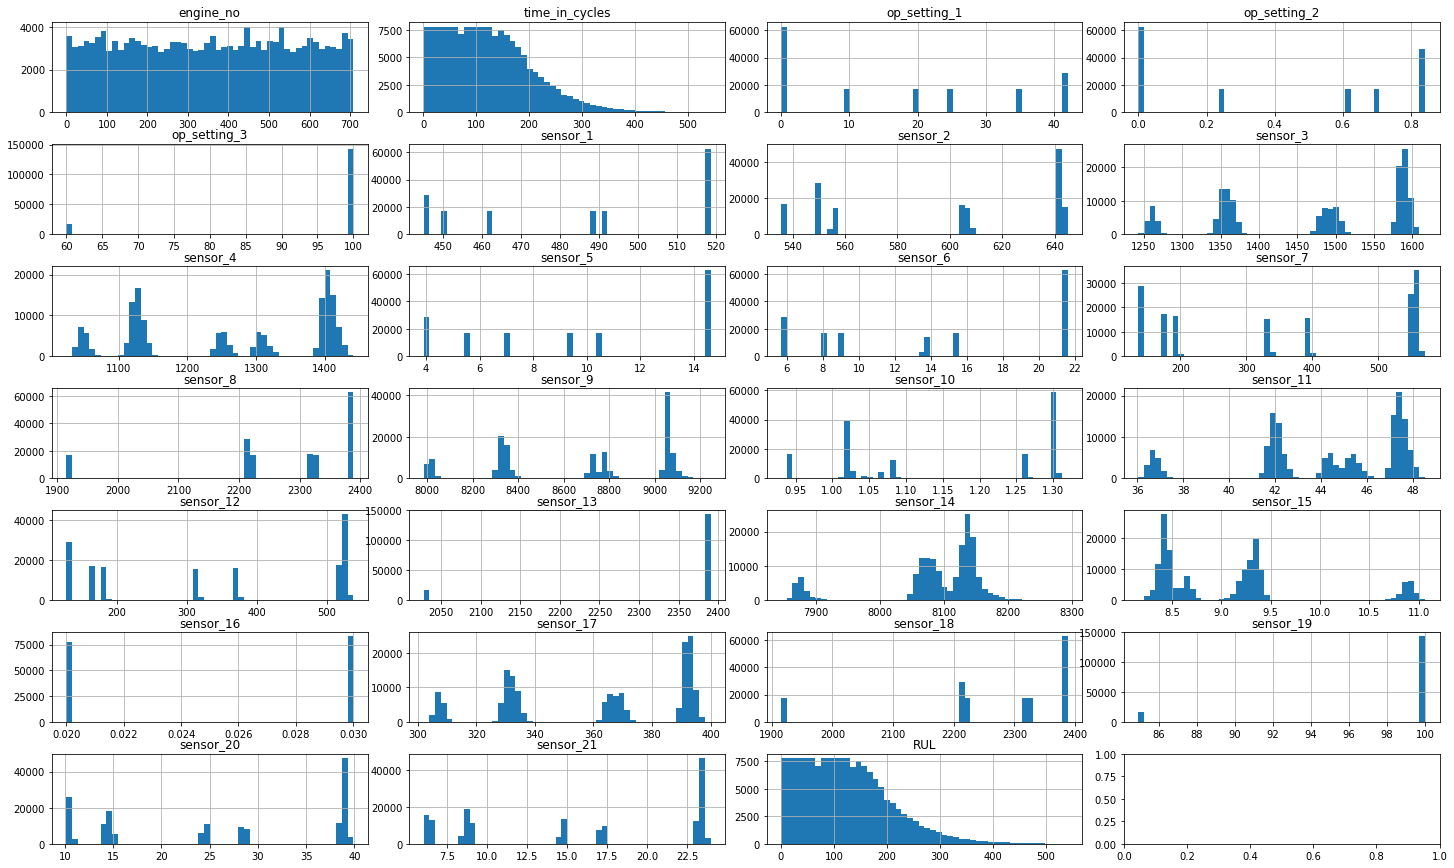

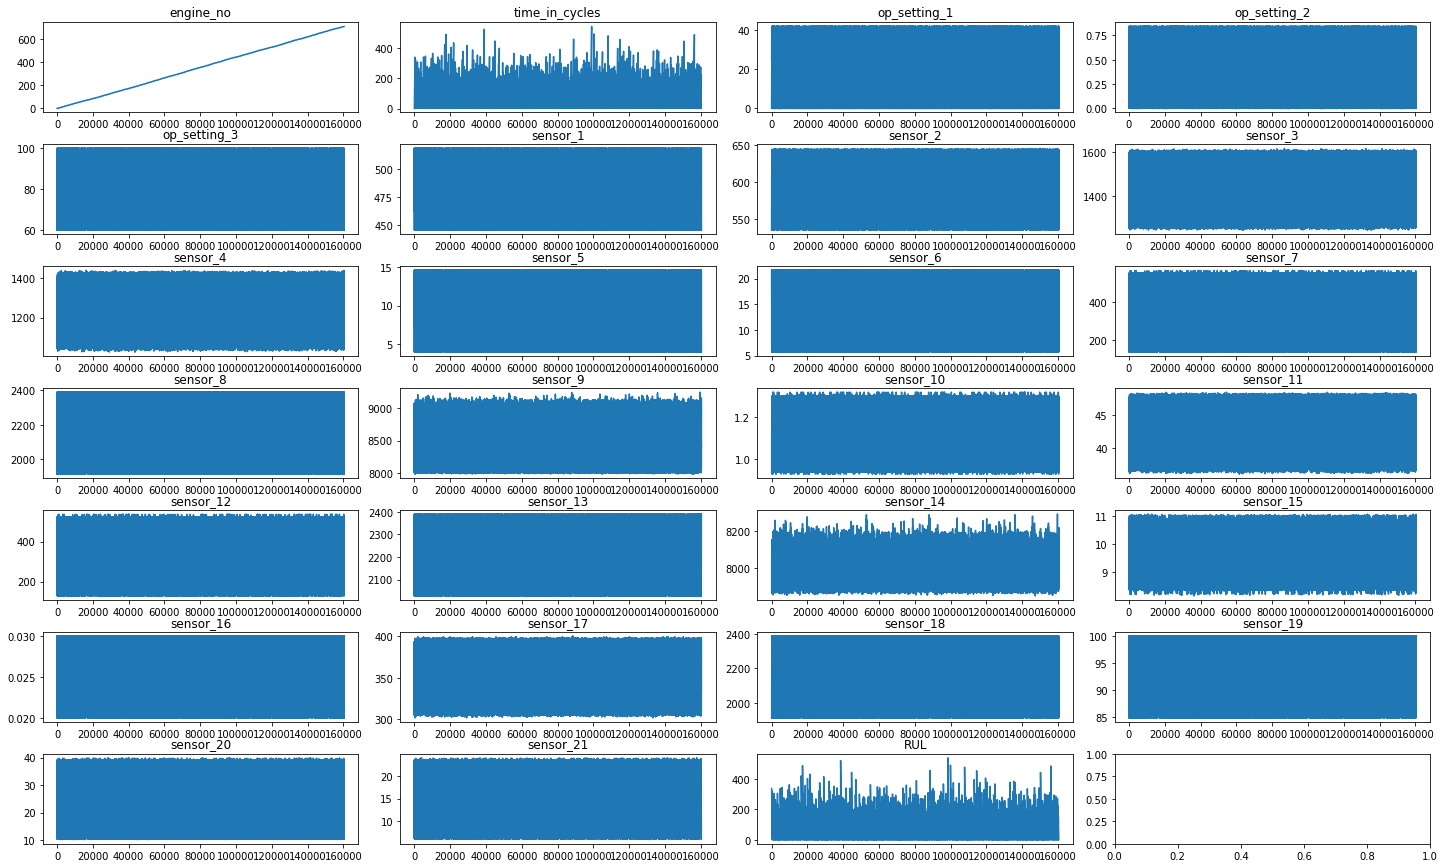

In [49]:
### Draw Histogram with all columns in dataset ###
#************************************************#
# 전체 데이터를 히스토그램으로 표현
def visualize_hist(dataset):
    # 7 * 4로 그래프를 배치하며, 각 그래프의 크기는 20 * 12
    fig, ax = plt.subplots(ncols=4, nrows=7, figsize=(20,12))
    plt.tight_layout()
    
    for column_index, column_name in enumerate(dataset):
        graph_row = int(column_index // 4)        # 각 그래프의 row
        graph_col = int(column_index % 4)
        # bins : 막대 개수, ax : 축
        dataset[column_name].hist(bins=50, ax=ax[graph_row, graph_col])
        ax[graph_row, graph_col].set_title(column_name)     # (row, col)에 위치한 그래프의 제목 지정
#************************************************#


### Draw Plot with three "plot_list" columns ###
#**********************************************#
def visualize_plot(dataset):
    # 7 * 4로 그래프 표현
    fig, ax = plt.subplots(ncols=4, nrows=7, figsize=(20,12))
    plt.tight_layout()
    for column_index, column_name in enumerate(dataset):
        graph_row = int(column_index // 4)
        graph_col = int(column_index % 4)
        dataset[column_name].plot(ax=ax[graph_row, graph_col])
        ax[graph_row, graph_col].set_title(column_name)
#**********************************************#


visualize_hist(dataset)

# Is there a large outlier??
visualize_plot(dataset)

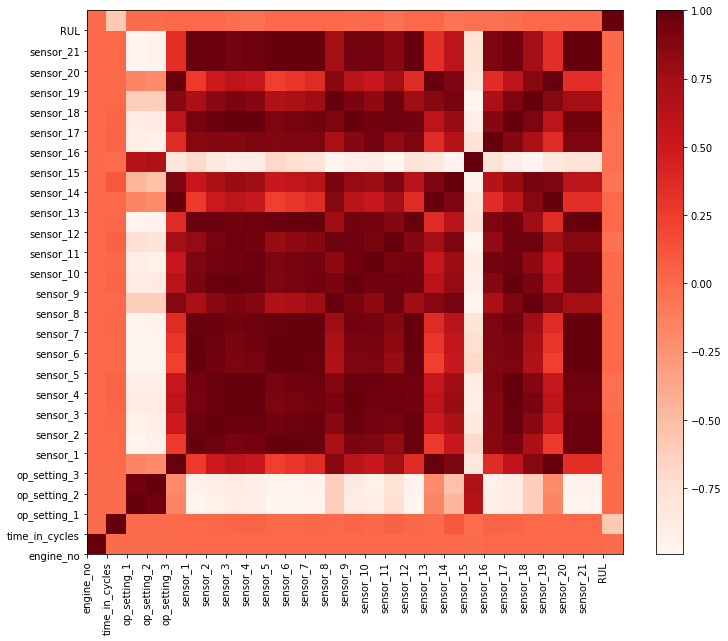

In [23]:
# RUL과 변수(features) 간 상관관계 표현
corr = dataset.corr()
fig, ax = plt.subplots(figsize=(12,10))
heatmap = ax.pcolor(corr, cmap=plt.cm.Reds, vmax=1.0)
ax.set_xticks(np.arange(corr.shape[0]))
ax.set_yticks(np.arange(corr.shape[1]))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.columns)
fig.colorbar(heatmap, ax=ax)

In [24]:
# Assign Features/Target variable

X = dataset.drop(columns=metacol).iloc[:,:-1]
y = dataset['RUL'].values

In [29]:
# See which features are the most important

from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor()
reg = RandomForestRegressor(n_estimators = 200, max_depth = 15)
reg.fit(X, y)
y_pred = reg.predict(X)
print("complete")

importances = reg.feature_importances_
columns=['col', 'val']
pd_importances = pd.DataFrame(columns=columns)
for i, x in enumerate(X.columns):
    pd_importances.loc[i] = [x, importances[i]]

# Get the most important columns in top10    
important_col = pd_importances.sort_values(by='val', ascending=False).reset_index()
print(important_col)

complete
    index           col           val
0      15     sensor_13  3.333021e-01
1      13     sensor_11  2.055543e-01
2      17     sensor_15  1.289372e-01
3      11      sensor_9  7.342138e-02
4       8      sensor_6  5.109003e-02
5       6      sensor_4  5.101447e-02
6      16     sensor_14  3.114608e-02
7      14     sensor_12  2.495157e-02
8       9      sensor_7  2.136990e-02
9      10      sensor_8  1.589372e-02
10      4      sensor_2  1.269222e-02
11      5      sensor_3  1.243138e-02
12     23     sensor_21  1.104437e-02
13     22     sensor_20  8.652607e-03
14      0  op_setting_1  8.202740e-03
15      1  op_setting_2  5.043323e-03
16     19     sensor_17  4.378589e-03
17     12     sensor_10  5.943799e-04
18     18     sensor_16  2.647926e-04
19     20     sensor_18  7.058202e-06
20      7      sensor_5  4.089561e-06
21      3      sensor_1  3.703202e-06
22     21     sensor_19  8.906299e-09
23      2  op_setting_3  9.171200e-10


In [30]:
# Get the most important columns in top18 
important_col = important_col.loc[:19, 'col']
print(important_col)

0        sensor_13
1        sensor_11
2        sensor_15
3         sensor_9
4         sensor_6
5         sensor_4
6        sensor_14
7        sensor_12
8         sensor_7
9         sensor_8
10        sensor_2
11        sensor_3
12       sensor_21
13       sensor_20
14    op_setting_1
15    op_setting_2
16       sensor_17
17       sensor_10
18       sensor_16
19       sensor_18
Name: col, dtype: object


In [56]:
# Search the best hyper-parameter using Optuna integrated LightGBM
print(dataset.describe())

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import optuna.integration.lightgbm as lgb
import optuna
optuna.logging.set_verbosity(optuna.logging.CRITICAL)

params = {
    'objective': 'mean_squared_error',
    'metric': 'rmse',
    'verbosity': -1
}


           engine_no  time_in_cycles   op_setting_1   op_setting_2  \
count  160359.000000   160359.000000  160359.000000  160359.000000   
mean      353.441665      123.331338      17.211973       0.410004   
std       205.969348       83.538146      16.527988       0.367938   
min         0.000000        1.000000      -0.008700      -0.000600   
25%       172.000000       57.000000       0.001300       0.000200   
50%       355.000000      114.000000      19.998100       0.620000   
75%       530.000000      173.000000      35.001500       0.840000   
max       708.000000      543.000000      42.008000       0.842000   

        op_setting_3       sensor_1       sensor_2       sensor_3  \
count  160359.000000  160359.000000  160359.000000  160359.000000   
mean       95.724344     485.840890     597.361022    1467.035653   
std        12.359044      30.420388      42.478516     118.175261   
min        60.000000     445.000000     535.480000    1242.670000   
25%       100.000000    

In [58]:
# Data Preprocessing
scaler = StandardScaler()
X = scaler.fit_transform(dataset.loc[:,important_col].values)
print(X(dataset.columns))
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)


AttributeError: 'numpy.ndarray' object has no attribute 'cols'